In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv('../data/raw_listings.csv')

print(f"Raw data shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:")
df.head()

Raw data shape: (420, 11)

Column names: ['source', 'location', 'address', 'property_type', 'bedrooms', 'bathrooms', 'parking', 'size_sqft', 'price_kes', 'listing_url', 'listing_date']

Missing values:
source            0
location          0
address           0
property_type     0
bedrooms          9
bathrooms        43
parking           1
size_sqft         0
price_kes         0
listing_url       0
listing_date      0
dtype: int64

First 5 rows:


,source,location,address,property_type,bedrooms,bathrooms,parking,size_sqft,price_kes,listing_url,listing_date
0,property24,Westlands,"Westlands Rd Nairobi, Westlands, Nairobi",Apartment,1.0,1.0,1.0,732,8940000,https://www.property24.co.ke/1-bedroom-apartme...,2026-02-23
1,property24,Westlands,"Westlands Rd Nairobi, Westlands, Nairobi",Apartment,1.0,1.0,1.0,732,8940000,https://www.property24.co.ke/1-bedroom-apartme...,2026-02-23
2,property24,Syokimau,"Mombasa Road Nairobi, Syokimau, Nairobi",Apartment,2.0,2.0,1.0,990,7500000,https://www.property24.co.ke/2-bedroom-apartme...,2026-02-23
3,property24,Westlands,"Rhapta Terraces Rhapta Road, Westlands, Nairobi",Apartment,1.0,1.0,1.0,753,9200000,https://www.property24.co.ke/1-bedroom-apartme...,2026-02-23
4,property24,Westlands,"Rhapta Terraces Rhapta Road, Westlands, Nairobi",Apartment,1.0,1.0,1.0,721,9000000,https://www.property24.co.ke/1-bedroom-apartme...,2026-02-23


In [3]:
before = len(df)
df = df.drop_duplicates(subset='listing_url', keep='first')
after = len(df)

print(f"Rows before: {before}")
print(f"Rows after: {after}")
print(f"Duplicates removed: {before - after}")

Rows before: 420
Rows after: 418
Duplicates removed: 2


In [4]:
print("Missing values BEFORE treatment:")
print(df.isnull().sum())

df['bedrooms'] = df.groupby('property_type')['bedrooms'].transform(
    lambda x: x.fillna(x.median())
)

df['bathrooms'] = df.groupby('bedrooms')['bathrooms'].transform(
    lambda x: x.fillna(x.median())
)

df['parking'] = df['parking'].fillna(1)

df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['parking'] = df['parking'].astype(int)

print("\nMissing values AFTER treatment:")
print(df.isnull().sum())

Missing values BEFORE treatment:
source            0
location          0
address           0
property_type     0
bedrooms          9
bathrooms        43
parking           1
size_sqft         0
price_kes         0
listing_url       0
listing_date      0
dtype: int64

Missing values AFTER treatment:
source           0
location         0
address          0
property_type    0
bedrooms         0
bathrooms        0
parking          0
size_sqft        0
price_kes        0
listing_url      0
listing_date     0
dtype: int64


In [5]:
print("Locations BEFORE standardization:")
print(df['location'].value_counts())

df['location'] = df['location'].str.strip().str.title()

location_mapping = {
    'Westlands Rd': 'Westlands',
    'Lower Kabete': 'Kabete',
    'Kiambu Road': 'Kiambu Rd',
    'Riverside Drive': 'Riverside',
}
df['location'] = df['location'].replace(location_mapping)

print("\nLocations AFTER standardization:")
print(df['location'].value_counts())

Locations BEFORE standardization:
location
Westlands        234
Kilimani          77
Kileleshwa        54
Syokimau          14
Lavington         10
Riverside          8
Runda              6
Mirema             3
Kiambu Road        3
Lower Kabete       2
Spring Valley      2
Kitisuru           2
Muthangari         1
Loresho            1
Karen              1
Name: count, dtype: int64

Locations AFTER standardization:
location
Westlands        234
Kilimani          77
Kileleshwa        54
Syokimau          14
Lavington         10
Riverside          8
Runda              6
Mirema             3
Kiambu Rd          3
Kabete             2
Spring Valley      2
Kitisuru           2
Muthangari         1
Loresho            1
Karen              1
Name: count, dtype: int64


In [6]:

Q1 = df['price_kes'].quantile(0.25)
Q3 = df['price_kes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: KES {Q1:,.0f}")
print(f"Q3: KES {Q3:,.0f}")
print(f"IQR: KES {IQR:,.0f}")
print(f"\nLower bound: KES {lower_bound:,.0f}")
print(f"Upper bound: KES {upper_bound:,.0f}")

before = len(df)
df = df[(df['price_kes'] >= lower_bound) & (df['price_kes'] <= upper_bound)]
after = len(df)

print(f"\nOutliers removed: {before - after}")
print(f"Remaining rows: {after}")

Q1: KES 8,200,000
Q3: KES 22,537,500
IQR: KES 14,337,500

Lower bound: KES -13,306,250
Upper bound: KES 44,043,750

Outliers removed: 22
Remaining rows: 396


In [7]:

df['price_per_sqft'] = (df['price_kes'] / df['size_sqft']).round(2)

df['listing_date'] = pd.to_datetime(df['listing_date'])
df['listing_month'] = df['listing_date'].dt.month
df['listing_year'] = df['listing_date'].dt.year

high_end = ['Karen', 'Runda', 'Muthaiga', 'Gigiri', 'Lavington',
            'Westlands', 'Riverside', 'Parklands']
mid_range = ['Kilimani', 'Kileleshwa', 'Ngong Road', 'South B',
             'South C', 'Upperhill', 'Syokimau']

def assign_tier(location):
    if location in high_end:
        return 'High End'
    elif location in mid_range:
        return 'Mid Range'
    else:
        return 'Affordable'

df['location_tier'] = df['location'].apply(assign_tier)

df['total_rooms'] = df['bedrooms'] + df['bathrooms']

df['bed_bath_ratio'] = (df['bedrooms'] / df['bathrooms']).round(2)

print("New features added:")
print(df[['price_per_sqft', 'listing_month', 'location_tier',
          'total_rooms', 'bed_bath_ratio']].head())
print(f"\nLocation tier breakdown:")
print(df['location_tier'].value_counts())

New features added:
   price_per_sqft  listing_month location_tier  total_rooms  bed_bath_ratio
0        12213.11              2      High End            2             1.0
1        12213.11              2      High End            2             1.0
2         7575.76              2     Mid Range            4             1.0
3        12217.80              2      High End            2             1.0
4        12482.66              2      High End            2             1.0

Location tier breakdown:
location_tier
High End      247
Mid Range     139
Affordable     10
Name: count, dtype: int64


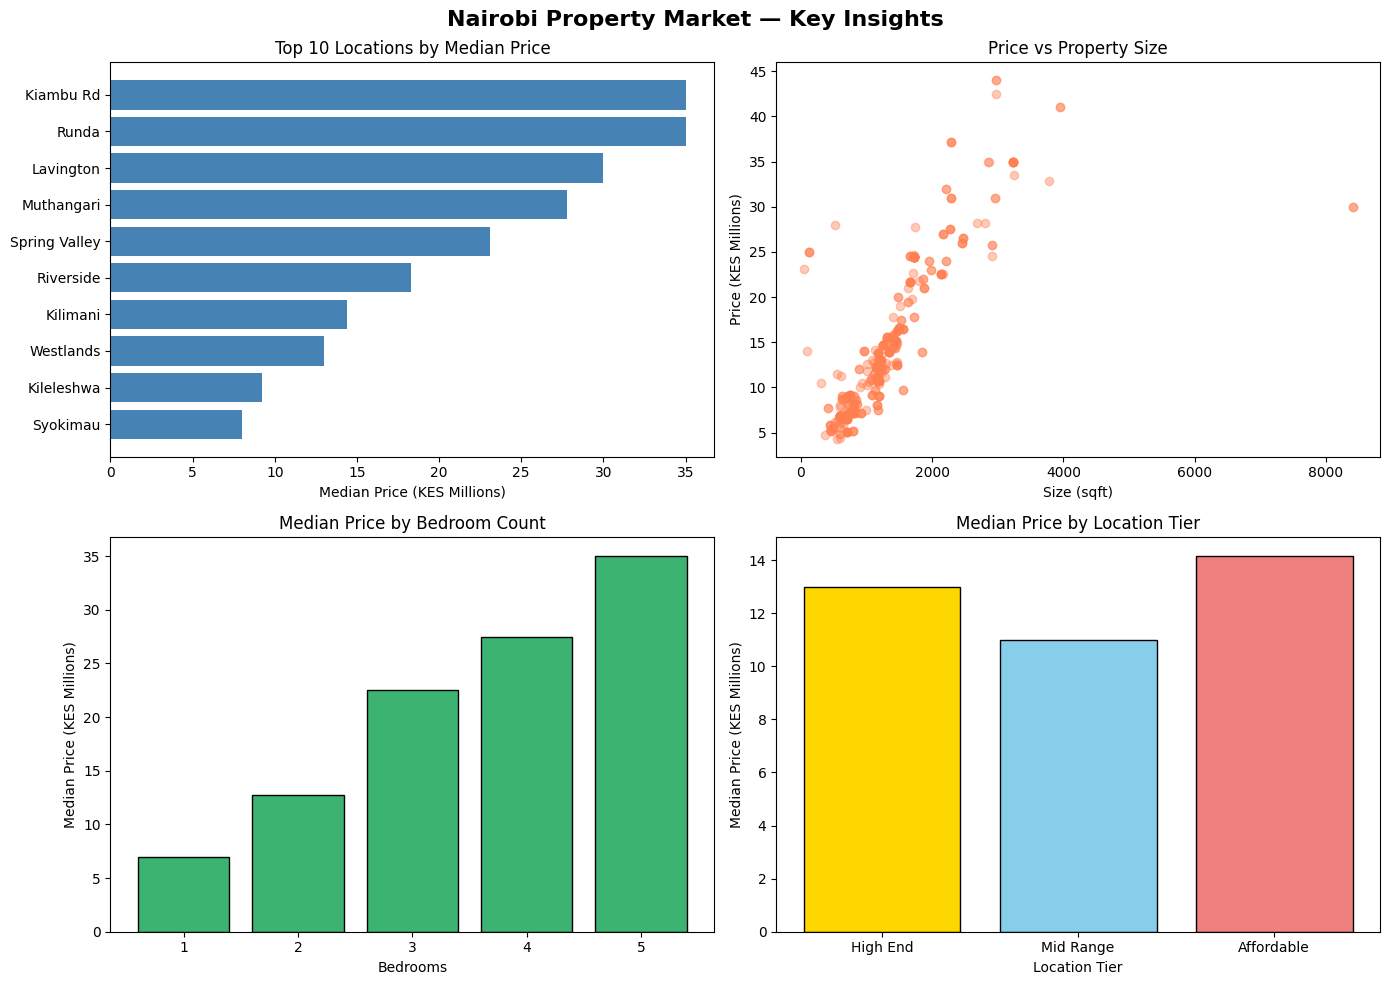

Charts saved to docs/eda_visuals.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Nairobi Property Market — Key Insights', 
             fontsize=16, fontweight='bold')

location_prices = (df.groupby('location')['price_kes']
                   .median()
                   .sort_values(ascending=False)
                   .head(10))
axes[0,0].barh(location_prices.index, location_prices.values / 1e6, 
               color='steelblue')
axes[0,0].set_title('Top 10 Locations by Median Price')
axes[0,0].set_xlabel('Median Price (KES Millions)')
axes[0,0].invert_yaxis()

axes[0,1].scatter(df['size_sqft'], df['price_kes'] / 1e6, 
                  alpha=0.4, color='coral')
axes[0,1].set_title('Price vs Property Size')
axes[0,1].set_xlabel('Size (sqft)')
axes[0,1].set_ylabel('Price (KES Millions)')

bedroom_prices = df.groupby('bedrooms')['price_kes'].median() / 1e6
axes[1,0].bar(bedroom_prices.index, bedroom_prices.values, 
              color='mediumseagreen', edgecolor='black')
axes[1,0].set_title('Median Price by Bedroom Count')
axes[1,0].set_xlabel('Bedrooms')
axes[1,0].set_ylabel('Median Price (KES Millions)')


tier_order = ['High End', 'Mid Range', 'Affordable']
tier_prices = df.groupby('location_tier')['price_kes'].median() / 1e6
tier_prices = tier_prices.reindex(tier_order)
axes[1,1].bar(tier_prices.index, tier_prices.values,
              color=['gold', 'skyblue', 'lightcoral'], edgecolor='black')
axes[1,1].set_title('Median Price by Location Tier')
axes[1,1].set_xlabel('Location Tier')
axes[1,1].set_ylabel('Median Price (KES Millions)')

plt.tight_layout()
plt.savefig('../docs/eda_visuals.png', dpi=150, bbox_inches='tight')
plt.show()
print("Charts saved to docs/eda_visuals.png")

In [9]:
df_clean = df.drop(columns=['source', 'address', 'listing_url', 'listing_date'])

df_clean.to_csv('../data/clean_listings.csv', index=False)

print(f"Clean data saved to data/clean_listings.csv")
print(f"Final shape: {df_clean.shape}")
print(f"\nFinal columns: {df_clean.columns.tolist()}")
print(f"\nSample:")
df_clean.head()

Clean data saved to data/clean_listings.csv
Final shape: (396, 13)

Final columns: ['location', 'property_type', 'bedrooms', 'bathrooms', 'parking', 'size_sqft', 'price_kes', 'price_per_sqft', 'listing_month', 'listing_year', 'location_tier', 'total_rooms', 'bed_bath_ratio']

Sample:


,location,property_type,bedrooms,bathrooms,parking,size_sqft,price_kes,price_per_sqft,listing_month,listing_year,location_tier,total_rooms,bed_bath_ratio
0,Westlands,Apartment,1,1,1,732,8940000,12213.11,2,2026,High End,2,1.0
1,Westlands,Apartment,1,1,1,732,8940000,12213.11,2,2026,High End,2,1.0
2,Syokimau,Apartment,2,2,1,990,7500000,7575.76,2,2026,Mid Range,4,1.0
3,Westlands,Apartment,1,1,1,753,9200000,12217.80,2,2026,High End,2,1.0
4,Westlands,Apartment,1,1,1,721,9000000,12482.66,2,2026,High End,2,1.0


In [11]:
print(" FINAL SUMMARY ")
print(f"Total clean listings: {len(df_clean)}")
print(f"Price range: KES {df_clean['price_kes'].min():,.0f} — KES {df_clean['price_kes'].max():,.0f}")
print(f"Median price: KES {df_clean['price_kes'].median():,.0f}")
print(f"\nLocation tiers:")
print(df_clean['location_tier'].value_counts())
print(f"\nAny remaining nulls:")
print(df_clean.isnull().sum())

 FINAL SUMMARY 
Total clean listings: 396
Price range: KES 4,310,000 — KES 44,000,000
Median price: KES 12,500,000

Location tiers:
location_tier
High End      247
Mid Range     139
Affordable     10
Name: count, dtype: int64

Any remaining nulls:
location          0
property_type     0
bedrooms          0
bathrooms         0
parking           0
size_sqft         0
price_kes         0
price_per_sqft    0
listing_month     0
listing_year      0
location_tier     0
total_rooms       0
bed_bath_ratio    0
dtype: int64
